In [6]:
import os
import re
from pathlib import Path
import glob
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from skimage.io import imread
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_dir = Path("/content/drive/MyDrive/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray")

In [9]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [10]:
trainNormal = train_dir / 'NORMAL'
trainPneumonia = train_dir / 'PNEUMONIA'

normalCases = trainNormal.glob('*jpeg')
pneumoniaCases = trainPneumonia.glob('*jpeg')

train_data = []
for img in normalCases:
    train_data.append((img, 0))
for img in pneumoniaCases:
    train_data.append((img, 1))

trainDf = pd.DataFrame(train_data, columns = ['Image Path', 'Label'], index = None)
trainDf = trainDf.sample(frac = 1.).reset_index(drop = True)
trainDf.head(10)

,Image Path,Label
0,/content/drive/MyDrive/Project/Pneumonia-Detec...,0
1,/content/drive/MyDrive/Project/Pneumonia-Detec...,0
2,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
3,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
4,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
5,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
6,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
7,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
8,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
9,/content/drive/MyDrive/Project/Pneumonia-Detec...,0


1    2034
0    1209
Name: Label, dtype: int64


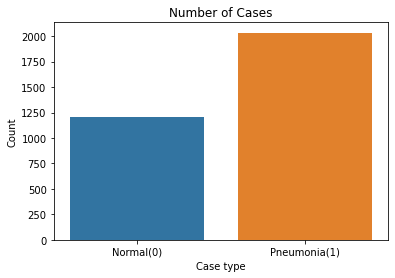

In [11]:
caseCount = trainDf['Label'].value_counts()
print(caseCount)
plt.figure(figsize = (6, 4))
sns.barplot(x = caseCount.index, y = caseCount.values)
plt.title('Number of Cases')
plt.xlabel('Case type')
plt.ylabel('Count')
plt.xticks(range(len(caseCount.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

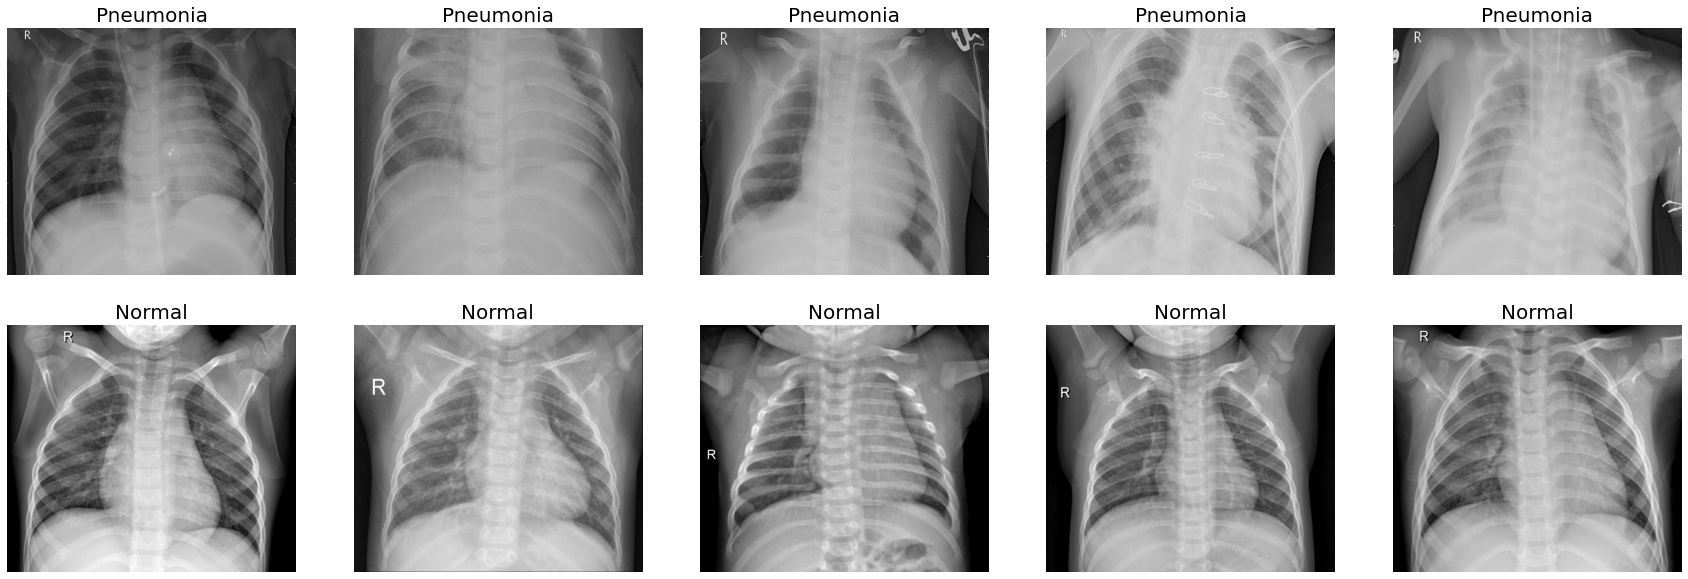

In [12]:
samplesPneumonia = (trainDf[trainDf['Label'] == 1]['Image Path'].iloc[:5]).tolist()
samplesNormal = (trainDf[trainDf['Label'] == 0]['Image Path'].iloc[:5]).tolist()

totalSamples = samplesPneumonia + samplesNormal
del samplesPneumonia, samplesNormal

f, ax = plt.subplots(2, 5, figsize=(30,10))
for i in range(0, 10):
    img = imread(totalSamples[i])
    ax[i // 5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i // 5, i % 5].set_title("Pneumonia", size=20)
    else:
        ax[i // 5, i % 5].set_title("Normal", size=20)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')

plt.show()

#All images will be rescaled by 1./255.

In [13]:
trainDataGen = ImageDataGenerator( rescale = 1.0/255.,
                                  rotation_range=20 ,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.6,0.9],
                                  fill_mode='nearest')
testDataGen = ImageDataGenerator( rescale = 1.0/255)

#1)Flow training images in batches of 32 using trainDataGen generator
#2)Flow validation images using testDataGen generator
#3)Flow validation images using testDataGen generator

In [14]:
trainGen = trainDataGen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(300, 300))     

validGen =  testDataGen.flow_from_directory(val_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

testGen =  testDataGen.flow_from_directory(test_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

Found 3243 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
trainGen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#viualize images after the data augmentation

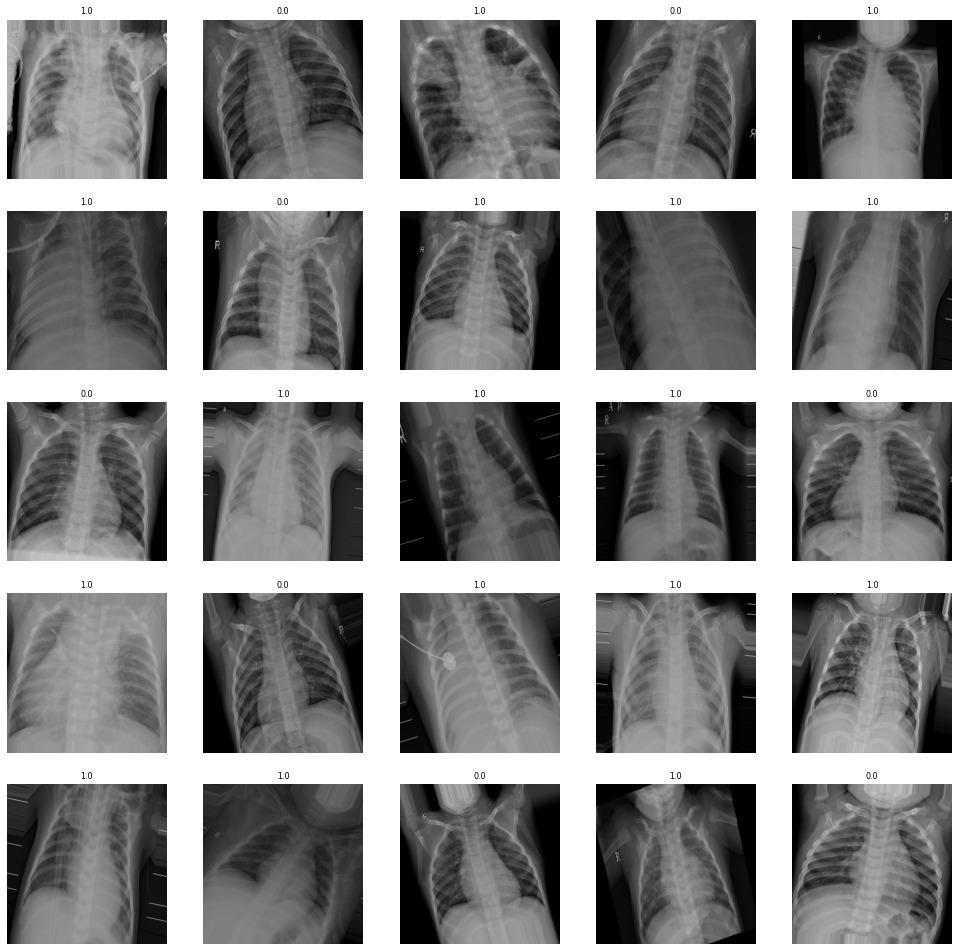

In [16]:
x_batch, y_batch = next(trainGen)
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (17,17))

# flaten the matrix into array
axes = axes.ravel() 
for i in np.arange(0, W * H): 

    # Select a random image
    image = x_batch[i]
    # read and display an image with the selected index    
    axes[i].imshow( image )
    axes[i].set_title(y_batch[i], fontsize = 8) 
    axes[i].axis('off')

In [18]:
mobilenetModel = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in mobilenetModel.layers:
    layer.trainable=False
    
x = mobilenetModel.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model3 = tf.keras.Model(inputs=mobilenetModel.input, outputs=predictions)

# to avoid overfitting
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
learningRate = tf.keras.callbacks.ReducelearningRateOnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [19]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           

In [20]:
bestModel = ModelCheckpoint('.mdl_wts.hdf5', save_best_only = True, monitor = 'val_accuracy')

In [21]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', 
                             verbose=1, 
                             monitor='val_accuracy',
                             save_best_only=True, 
                             mode='max')

In [23]:
history = model3.fit(trainGen ,epochs=15, 
                    validation_data=validGen,
                     steps_per_epoch=100,
                    callbacks=[checkpoint,earlyStopping,learningRate],
                    batch_size=32)

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9135
Epoch 1: val_accuracy improved from -inf to 0.93681, saving model to model-001-0.913495-0.936813.h5
100/100 [==============================] - 408s 4s/step - loss: 0.2112 - accuracy: 0.9135 - val_loss: 0.1835 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9393
Epoch 2: val_accuracy did not improve from 0.93681
100/100 [==============================] - 111s 1s/step - loss: 0.1555 - accuracy: 0.9393 - val_loss: 0.4530 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9443
Epoch 3: val_accuracy did not improve from 0.93681
100/100 [==============================] - 108s 1s/step - loss: 0.1507 - accuracy: 0.9443 - val_loss: 0.3370 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 4/15
100/100 [==============================] - ETA: 0s - loss: 0.128

#Evaluating the model on train and test

In [24]:
score = model3.evaluate(trainGen)
print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(testGen)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

102/102 [==============================] - 105s 1s/step - loss: 0.0954 - accuracy: 0.9608
Train Loss:  0.09543808549642563
Train Accuracy:  0.9608387351036072
20/20 [==============================] - 127s 7s/step - loss: 0.4352 - accuracy: 0.8093

Test loss:  0.43523645401000977
Test Accuracy:  0.8092948794364929


Text(0.5, 1.0, 'Accuracy Evolution')

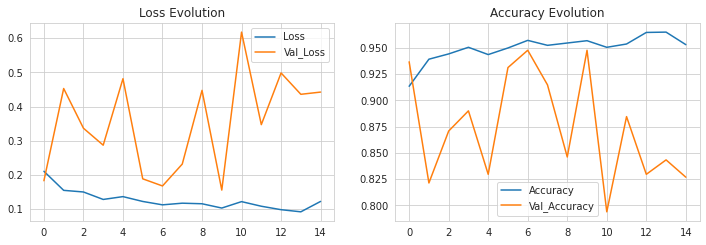

In [25]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [26]:
mobilenetModel.trainable = True

In [27]:
# how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenetModel.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenetModel.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [28]:
# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [29]:
len(model3.trainable_variables)

58

In [30]:
fineTuneEpochs = 10
epochsRawModel = 15

total_epochs =  epochsRawModel + fineTuneEpochs

history_fine =model3.fit(trainGen,epochs=total_epochs, 
                    validation_data=validGen,
                    steps_per_epoch=100,
                    callbacks=[checkpoint,earlyStopping,learningRate],
                    batch_size=32)

Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9242
Epoch 1: val_accuracy did not improve from 0.94780
100/100 [==============================] - 112s 1s/step - loss: 0.2290 - accuracy: 0.9242 - val_loss: 4.3307 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9566
Epoch 2: val_accuracy did not improve from 0.94780
100/100 [==============================] - 109s 1s/step - loss: 0.1173 - accuracy: 0.9566 - val_loss: 9.1923 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9689
Epoch 3: val_accuracy did not improve from 0.94780
100/100 [==============================] - 108s 1s/step - loss: 0.0949 - accuracy: 0.9689 - val_loss: 3.0184 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9711
Epoch 4: val_accuracy did no

In [31]:
# Evaluating the model on train and test
score = model3.evaluate(trainGen)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(testGen)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

102/102 [==============================] - 106s 1s/step - loss: 0.1054 - accuracy: 0.9735
Train Loss:  0.10541639477014542
Train Accuracy:  0.9734813570976257
20/20 [==============================] - 7s 304ms/step - loss: 0.4418 - accuracy: 0.8734

Test loss:  0.44180604815483093
Test Accuracy:  0.8733974099159241


Text(0.5, 1.0, 'Accuracy Evolution')

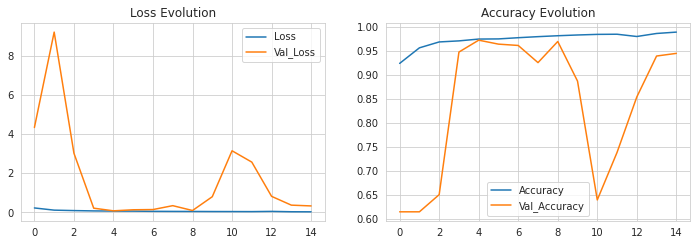

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

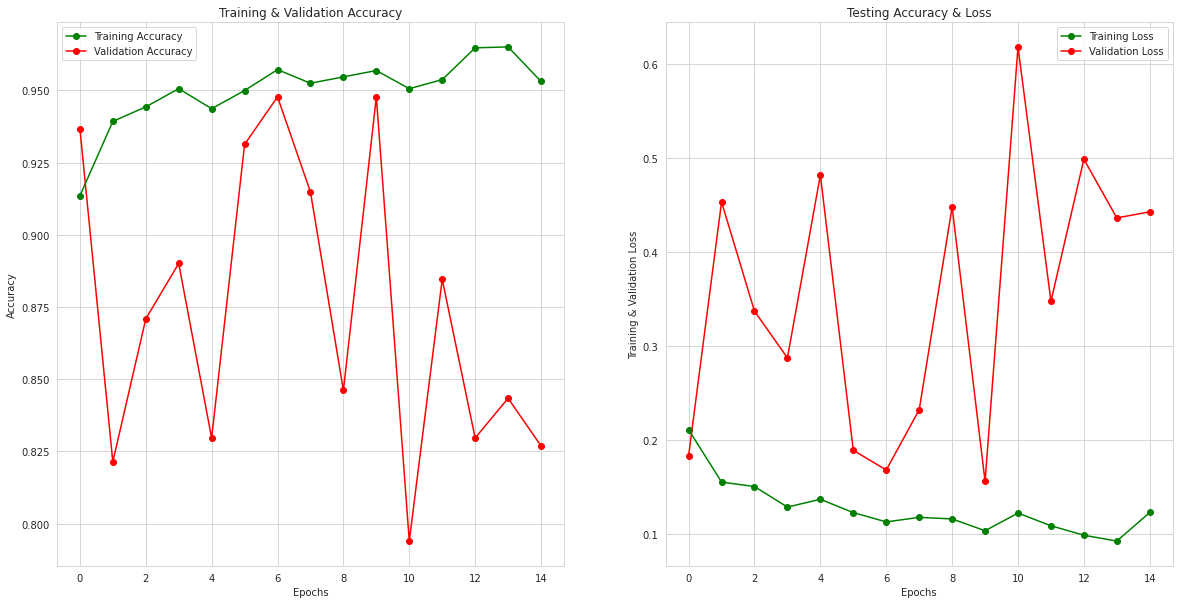

In [37]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [33]:
model3.save('tuned_mobilenet.h5')

In [34]:
final_model = tf.keras.models.load_model('tuned_mobilenet.h5')

In [35]:
y_pred = final_model.predict(testGen)

20/20 [==============================] - 7s 302ms/step


In [36]:
final_model.evaluate(testGen)

20/20 [==============================] - 7s 299ms/step - loss: 0.4418 - accuracy: 0.8734


[0.44180604815483093, 0.8733974099159241]

#Confution Matrix and Classification Report after fine-tune

12/12 [==============================] - 4s 340ms/step - loss: 0.3323 - accuracy: 0.9451
Confusion Matrix
[[140   0]
 [ 20 204]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.88      1.00      0.93       140
   PNEUMONIA       1.00      0.91      0.95       224

    accuracy                           0.95       364
   macro avg       0.94      0.96      0.94       364
weighted avg       0.95      0.95      0.95       364



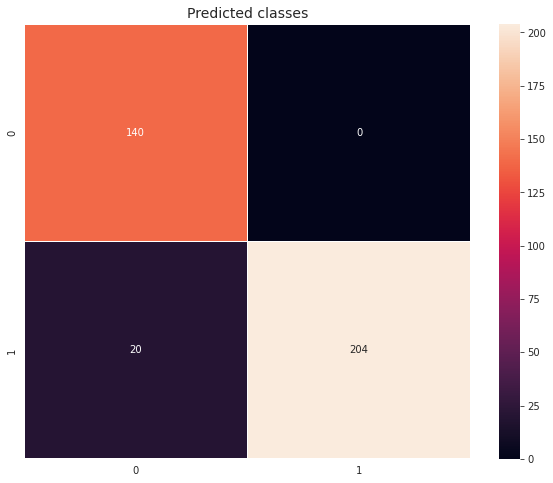

In [43]:
Y_pred = model3.predict(validGen)
model3.evaluate(validGen)
y_pred= np.where(Y_pred>0.5, 1, 0)
print('Confusion Matrix')
print(confusion_matrix(validGen.classes, y_pred))
print('Classification Report')
target_names = os.listdir(train_dir)
print(classification_report(validGen.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(validGen.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

#Confution Matrix and Classification Report Before fine-tune

20/20 [==============================] - 7s 304ms/step - loss: 0.4418 - accuracy: 0.8734
Confusion Matrix
[[198  36]
 [ 43 347]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.82      0.85      0.83       234
   PNEUMONIA       0.91      0.89      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.87      0.87      0.87       624



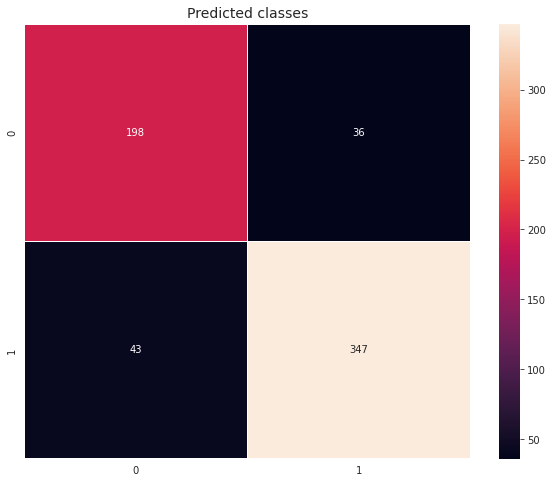

In [44]:
Y_pred = model3.predict(testGen)
model3.evaluate(testGen)
y_pred= np.where(Y_pred>0.5, 1, 0)
print('Confusion Matrix')
print(confusion_matrix(testGen.classes, y_pred))
print('Classification Report')
target_names = os.listdir(train_dir)
print(classification_report(testGen.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(testGen.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()